# Project:  Investigate the possibility of opening a fitness studio in Manhattan


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#data">Data Collection</a></li>
<li><a href="#explore">Download and explore NewYork Dataset</a></li>
<li><a href="#clean">Data Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#cluster">Cluster the Neighborhoods</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'> </a>
# Introduction: 
## Gyms are becoming more and more like restaurants.  There is one now on every corner.  And like restaturants many go out of business.  So,  can we find the best neighborhood that would have the best chance of success?

<a id='data'> </a>
# Data Collection
## I will be using New York City Neighborhood Names point file that was created as a guide to New York City’s neighborhoods that appear on the web resource, “New York: A City of Neighborhoods.
## FourSquare will also be used to obtain appropriate information for each neighborhood

****

**Download the dependencies**

In [91]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('libraries imported')


libraries imported


<a id='explore'> </a>
#  Download and explore New York Dataset

In [92]:
import urllib.request
url='https://cocl.us/new_york_dataset'
filename= 'newyork_data.json'
urllib.request.urlretrieve(url,filename)
print('Data downloaded!')

Data downloaded!


**load and explore the data**

In [93]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

**create variable to hold all neighborhoods that are in the features key**

In [94]:
neighborhoods_data = newyork_data['features']

**transform data into a pandas dataframe**

In [95]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_manhattan = pd.DataFrame(columns=column_names)

**loop thru data and populate dataFrame.  For borough, I only want Manhattan so I am checking if borough is Manhattan
if yes, i will populate else I will skip**

In [96]:
for data in neighborhoods_data:
    if data['properties']['borough'] == 'Manhattan':
        borough =  data['properties']['borough'] 
        
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        df_manhattan = df_manhattan.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

**verify dataframe has only the borough Manhattan and all its neighborhoods**

In [97]:
df_manhattan.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


**check the last few rows**

In [98]:
df_manhattan.tail()

,Borough,Neighborhood,Latitude,Longitude
35,Manhattan,Turtle Bay,40.752042,-73.967708
36,Manhattan,Tudor City,40.746917,-73.971219
37,Manhattan,Stuyvesant Town,40.731000,-73.974052
38,Manhattan,Flatiron,40.739673,-73.990947
39,Manhattan,Hudson Yards,40.756658,-74.000111


In [99]:
df_manhattan.shape
print(f'there are {df_manhattan.shape[0]} Neighborhoods in Manhattan')

there are 40 Neighborhoods in Manhattan


**Setup the Foursquare keys for access**

In [100]:
CLIENT_ID = 'WYZXGZA1N1S2U1QCV0HV253WPJJI1A1YGA1NQMUHAG1EBAJJ' #  Foursquare ID
CLIENT_SECRET = 'DN3PNOIVAM5P20VVYTJIEY2OTA52KVJ3BZVHBYVRJ2YKYKOL' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version


print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: WYZXGZA1N1S2U1QCV0HV253WPJJI1A1YGA1NQMUHAG1EBAJJ
CLIENT_SECRET:DN3PNOIVAM5P20VVYTJIEY2OTA52KVJ3BZVHBYVRJ2YKYKOL


**convert Neighborhood to lowercase and replace spaces with underscore
   convert Borough to lowercase
   convert column titles to lower case**

In [101]:
df_manhattan['Neighborhood'] = df_manhattan.loc[:,'Neighborhood'].str.replace(" ",'_').str.lower()

  
df_manhattan['Borough']= df_manhattan.loc[:,'Borough'].str.lower()


df_manhattan.head(2)#verify

,Borough,Neighborhood,Latitude,Longitude
0,manhattan,marble_hill,40.876551,-73.910660
1,manhattan,chinatown,40.715618,-73.994279


In [102]:
df_manhattan.columns = map(str.lower, df_manhattan.columns)#convert columns titles to lowercase
df_manhattan.head(1)#verify

,borough,neighborhood,latitude,longitude
0,manhattan,marble_hill,40.876551,-73.91066


**we are only interested in the following neighborhoods in Manhattan.    These neighborhoods match our demographic**

In [103]:
neighborhood_list=['upper_west_side','gramercy','yorkville,','battery_park_city','tribeca','soho','greenwich_village','chelsea',
                   'upper_east_side', 'east_village', 'lincoln_square','midtown']

**category id's to be used with foursquare**

In [104]:
gym='4bf58dd8d48988d175941735'  #Gym/ Fitness Center


**use foursquare to get all neighborhoods we are interested in to open a gym . clean the json and structure into a pandas dataframe**

In [105]:
def getNearbyGyms(names, latitudes, longitudes, radius=500):
    
    LIMIT=100
    radius=500

    gyms_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        

        url = 'https://api.foursquare.com/v2/venues/explore?&categoryId={}, \
        &client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            gym,        
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby gym
        gyms_list.append([(
            name, 
            #lat, 
            #lng, 
            v['venue']['name'], 
            #v['venue']['location']['lat'], 
            #v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_gyms = pd.DataFrame([item for gym_list in gyms_list for item in gym_list])
    nearby_gyms.columns = ['neighborhood', 
                  #'neighborhood_Latitude', 
                  #'neighborhood_Longitude', 
                  'gym', 
                  #'gym_Latitude', 
                  #'gym_Longitude', 
                  'gym_category']
    
    return(nearby_gyms)

**creating a subset of manhattan dataframe for neighborhoods we are interested in
 this subset will be used in the call below for getNearbyGyms**

In [106]:
df_manhattan_gyms = df_manhattan[df_manhattan['neighborhood'].isin(neighborhood_list)]
df_manhattan_gyms.neighborhood.unique(), df_manhattan_gyms.head() #verify

(array(['upper_east_side', 'upper_west_side', 'lincoln_square', 'midtown',
        'chelsea', 'greenwich_village', 'east_village', 'tribeca', 'soho',
        'gramercy', 'battery_park_city'], dtype=object),
       borough     neighborhood   latitude  longitude
 8   manhattan  upper_east_side  40.775639 -73.960508
 12  manhattan  upper_west_side  40.787658 -73.977059
 13  manhattan   lincoln_square  40.773529 -73.985338
 15  manhattan          midtown  40.754691 -73.981669
 17  manhattan          chelsea  40.744035 -74.003116)

In [107]:

manhattan_gyms = getNearbyGyms(names=df_manhattan_gyms['neighborhood'],
                                   latitudes=df_manhattan_gyms['latitude'],
                                   longitudes=df_manhattan_gyms['longitude']
                                  )


In [108]:
manhattan_gyms.shape

(565, 3)

In [109]:
manhattan_gyms.head()

,neighborhood,gym,gym_category
0,upper_east_side,Chaise Fitness,Gym / Fitness Center
1,upper_east_side,CityRow,Gym / Fitness Center
2,upper_east_side,305 Fitness,Gym / Fitness Center
3,upper_east_side,Exceed Physical Culture,Gym / Fitness Center
4,upper_east_side,Crunch,Gym / Fitness Center


<a id='clean'> </a>
# Data Cleaning

In [110]:
manhattan_gyms['gym_category'].unique()

array(['Gym / Fitness Center', 'Yoga Studio', 'Spa', 'Gym',
       'Martial Arts Dojo', 'Weight Loss Center', "Doctor's Office",
       'Pilates Studio', 'Cycle Studio', 'Boxing Gym', 'Gymnastics Gym',
       'Residential Building (Apartment / Condo)', 'Gym Pool',
       'Climbing Gym', 'Chiropractor', 'Athletics & Sports', 'Hotel',
       'Hospital', 'Medical Center', 'Outdoor Gym', 'Track', 'Office',
       'Health & Beauty Service', 'Bike Shop'], dtype=object)

**create a list of the types of gyms we are interested in and drop the rest**

In [111]:
categories_list=['Gym / Fitness Center', 'Gym', 'Pilates Studio', 'Yoga Studio', 'Cycle Studio', 'Martial Arts Dojo',
                 'Boxing Gym', 'Climbing Gym']

In [112]:
#drop all rows that are NOT in the categories_list 
df_gyms = manhattan_gyms[manhattan_gyms['gym_category'].isin(categories_list)]
                                        

In [113]:
df_gyms['gym_category'].unique()#verify

array(['Gym / Fitness Center', 'Yoga Studio', 'Gym', 'Martial Arts Dojo',
       'Pilates Studio', 'Cycle Studio', 'Boxing Gym', 'Climbing Gym'],
      dtype=object)

**make all column names lowercase and replace space with underscore**
  

In [114]:
df_gyms.columns = [col.replace(" ","_").lower() for col in df_gyms.columns]



**change Gym / Fitness Center to just Gym**
  

In [115]:
df_gyms['gym_category']= df_gyms.loc[:,'gym_category'].replace('Gym / Fitness Center', 'Gym')
df_gyms['gym_category'].unique()

C:\Users\howar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array(['Gym', 'Yoga Studio', 'Martial Arts Dojo', 'Pilates Studio',
       'Cycle Studio', 'Boxing Gym', 'Climbing Gym'], dtype=object)

In [116]:
df_gyms.head(2)


,neighborhood,gym,gym_category
0,upper_east_side,Chaise Fitness,Gym
1,upper_east_side,CityRow,Gym


**get gym category for each neighborhood**


In [117]:
neighborhood_gyms = df_gyms.groupby(['neighborhood','gym_category'],as_index=False).count()


neighborhood_gyms.head()

,neighborhood,gym_category,gym
0,battery_park_city,Boxing Gym,2
1,battery_park_city,Gym,27
2,chelsea,Cycle Studio,2
3,chelsea,Gym,32
4,chelsea,Martial Arts Dojo,3



<a id='eda'> </a>
# Exploratory Data Analysis


**lets see total number of gyms overall for each neighborhood**

In [118]:
# load plotting dependencies
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
# one hot encoding
gym_onehot = pd.get_dummies(df_gyms[['gym_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gym_onehot['neighborhood'] = df_gyms['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [gym_onehot.columns[-1]] + list(gym_onehot.columns[:-1])
gym_onehot = gym_onehot[fixed_columns]

gym_onehot.head()

,neighborhood,Boxing Gym,Climbing Gym,Cycle Studio,Gym,Martial Arts Dojo,Pilates Studio,Yoga Studio
0,upper_east_side,0,0,0,1,0,0,0
1,upper_east_side,0,0,0,1,0,0,0
2,upper_east_side,0,0,0,1,0,0,0
3,upper_east_side,0,0,0,1,0,0,0
4,upper_east_side,0,0,0,1,0,0,0


**sum up all the different types of gyms in the neighborhoods**

In [120]:
gym_cnt = gym_onehot.loc[:,'Boxing Gym': 'Yoga Studio'].sum(axis=0).sort_values(ascending=False)


# ONE climbing gym in the neighborhoods we are interested in.  WHY?

In [121]:
neighborhood_gyms.query('gym_category == "Climbing Gym"')

,neighborhood,gym_category,gym
21,lincoln_square,Climbing Gym,1


**loop thru each neighborhood and pass to  function to plot bar chart for that neighborhood**

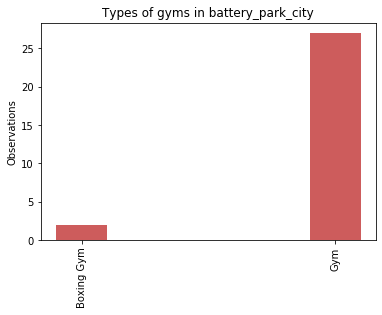

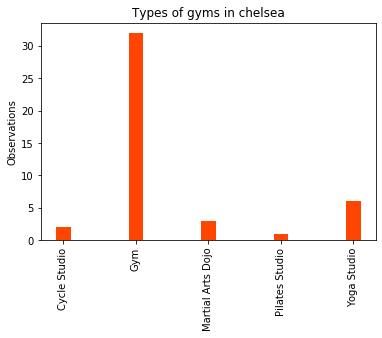

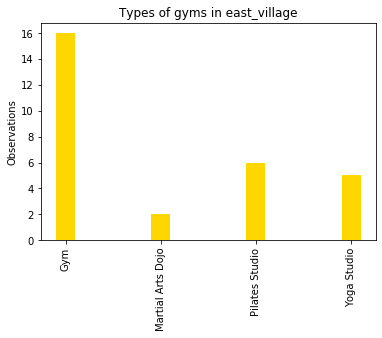

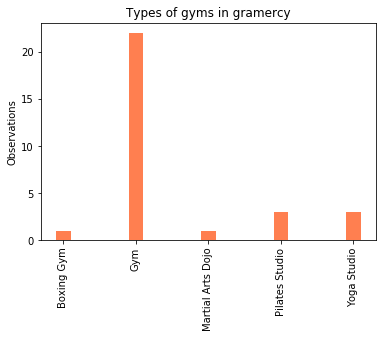

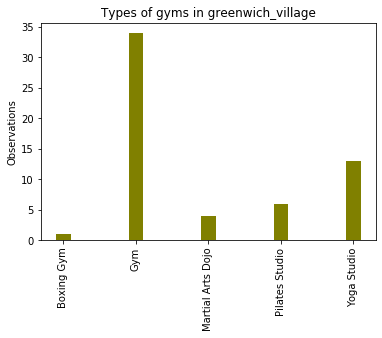

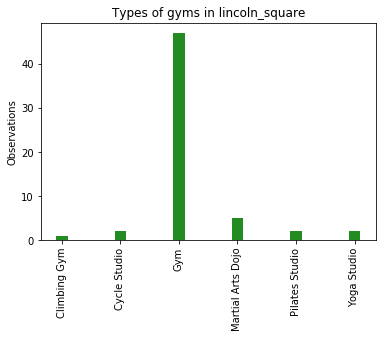

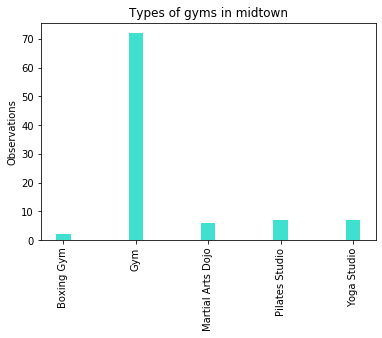

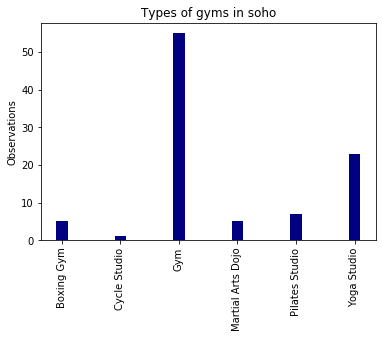

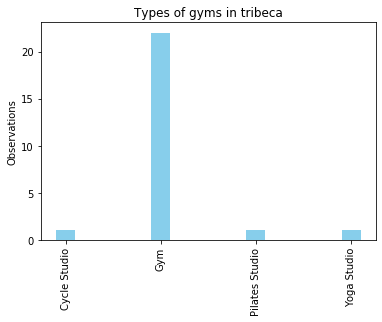

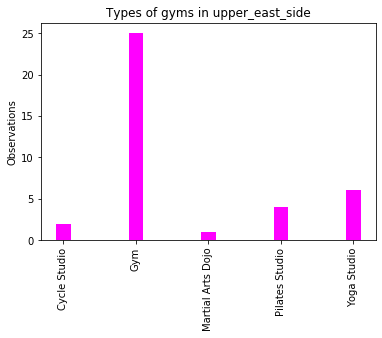

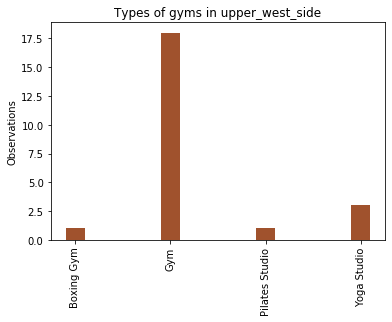

In [122]:
i=0 #set an index to be used for getting colors in the function being called (plotHoodGyms)
for hood in neighborhood_gyms['neighborhood'].unique():
    plotHoodGyms(hood,i)
    i+=1

In [123]:
def plotHoodGyms(hood,i):
    #set colors to use for the different bar charts for each neighborhood
    color_table=['#CD5C5C','#FF4500','#FFD700','#FF7F50','#808000','#228B22','#40E0D0',
                 '#000080','#87CEEB','#FF00FF','#A0522D']
    
    
    fig, ax = plt.subplots()
    hood_query = neighborhood_gyms.query('neighborhood ==@hood')
    gym_type = hood_query['gym_category']
    gym_type_total = hood_query['gym']
    #for col in hood_query:
        
    ax.bar(gym_type,gym_type_total,width=.2,color=color_table[i])
    
    
    ax.set_ylabel('Observations')
    ax.set_xticklabels(gym_type,rotation=90)
    ax.set_title(f'Types of gyms in {hood}')
    plt.show()
    

**create bar chart to show total number of gyms for all neighborhoods interested in**

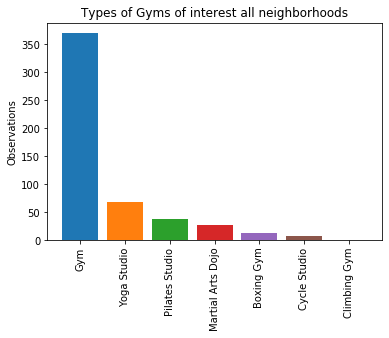

In [124]:
fig, ax = plt.subplots()
for i, col in enumerate(gym_cnt.index):
    
    ax.bar(col,gym_cnt[i])
    
ax.set_ylabel('Observations')
ax.set_xticklabels(gym_cnt.index,rotation=90)
ax.set_title('Types of Gyms of interest all neighborhoods')
plt.show()
    

**lets see the gym names to see if mulitple gyms in the neigborhoods and which ones are most common**

In [125]:
# one hot encoding
gym_name_onehot = pd.get_dummies(df_gyms[['gym']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gym_name_onehot['neighborhood'] = df_gyms['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [gym_name_onehot.columns[-1]] + list(gym_name_onehot.columns[:-1])
gym_name_onehot = gym_name_onehot[fixed_columns]

gym_name_onehot.head()

,neighborhood,10WEA Gym,10th Planet Brazilian Jiu Jitsu - NYC,14th Street Y,150 WEA Gym,1540 Broadway Gym,160 WEA Gym,180 Gym,180 WEA Gym,190 East 7th GYM,2 River Terrace Fitness Center,200 Rector Club,212 Pilates,225 Rector Place Gym and Studio,285 Gym,3 Lincoln Center Gym,302 Gym,305 Fitness,33 WEA Gym,445 5th Avenue Gym,5-Star Service Fitness Center,63 West Gym,75 West Street Gym,90 Washington Gym,911 Gym,993 Park Gym,9th Precinct Gym,A.R.T. Studio NYC,AArmy,AArmy Popup,ABC Sanctuary,AIC Fitness,AIRE gym,AKT INMOTION,AKT in Motion - SoHo,AVF gym,Abena Pilates,Absolute Body Pilates,Aerospa Gym @ Gramercy Park Hotel,Alexander Vater Fitness,Algonquin Fitness Center,Alo Yoga,Alphabet City Yoga,Alycea Ungaro's Real Pilates,American Express Fitness Center,Amplitude Vibration Studio,Anderson's Martial Arts,Anomaste (Anomaly Yoga by Jenny),Arc Athletics,Ashtanga Yoga NY,Asphalt Green,Asser Levy Recreation Center,Athleta Mind Over Madness Yoga,Athletic Club,Atmananda,Ave A Pilates,Avery Fitness Center,BIA Force,BJJ for Kids NYC,BK Pilates,Bandier : Studio B,Barefoot Tiger,Bari Soho,Barre TriBeca at MediaMath,Barry's Bootcamp,Bella Vita,Bk Pilates,Blink Fitness,Bode NYC - Upper East Side,Body Evolutions,Bonstar Fitness,Box + Flow (SOHO),Brace Wellness,Brass Pole Fitness,BrendanBFit,Brick New York,BurnStrong,CITYROW Upper East Side,CK Chu Tai Chi,CP Burn Pilates,CURRENT,Caliber,Canali club,Catalyst S.P.O.R.T.,Central Rock Gym,Centria Gym,Chaise Fitness,Chelsea Movements,Chelsea Piers Mind Body Studio,Chinese Hawaiian Kenpo Academy,Church Street Boxing Gym,Citi Fitness Center,City Wing Tsun Kung Fu,CityRow,Classes on the Cobblestones,Clockwork Jiu Jitsu,Club Pilates,Coban's Muay Thai Camp,Coliseum North Gym,Confit Inc,Conrad New York Fitness Center,Cordell Fitness,CorePower Yoga,Cornerstone Gym,Courtyard Fitness Center,Courtyard Marriott Downtown Fitness Center,CrossFit East River,CrossFit SPOT,Crossfit 212 NoHo,Crossfit Fifth Ave,Crossfit NYC - Upper West Side,Crossfit Spot,Crunch,Crunch - 19th Street,Crunch Fitness - 83rd Street,Cyrofuel,DLFit Pilates Wellness Studio,DMB Boxing,DOGPOUND,Dad's Sports Club,DailyBurn Gym @IAC,DanceBody,Dancebody,David Barreras Fitness,Debra Downs Yoga,DhoonyaFIT,Doonya,Dorchester Gym,Doubletree Fitness Center,Dream Downtown Fitness Center,Dream Gym,Drive495,EVE Gym,East End Row,East Midtown Plaza Fitness Center,Eastside Training,Elite Plus MMA,Elliot's Gym,Empire Hotel Gym,Epic Hybrid Training Center,Equinox Bond Street,Equinox Brookfield Place,Equinox Bryant Park,Equinox East 43rd Street,Equinox Highline,Equinox SoHo,Equinox Sports Club New York,Everybody Fights,Evolve Physical Therapy & Sports Rehabilitation,Exceed Physical Culture,Exhale,FIT® At The W Residences,FPC NYC,Fhitting Room UWS,FightWorksNYC,Fightworks,Finding Sukha Yoga Studio,Fit Pregnancy Club,Fit Ritual Studio,Fit46 Fitness Center,Fitness Center,Fitness Center @ 11 Howard,Fitness Center @ Empire Hotel,Fitness Center @ Hilton Garden Inn,Fitness Center at NBCUniversal,Fitness Center at the Chatwal,Fitness Center at the James,Fitness Center@Tribecca Grand Hotel,Fitness Room at Royalton,Five Points Academy,Flex Studios,Fluid Fitness,Flux Midtown,FlyBarre Lincoln Center,Flywheel Sports,Forward__Space,Freehand Fitness Center,Friday Night Fights,GP3 Functional Fitness,GYM NYC,Gem Gym,Gertrude Ederle Recreation Center,Gloveworx,Good Day Pilates,Google Double Rainbow Yoga Room,Google Fitness Room,Gotham Gym,Gotham Gym SoHo,Grasshopper Pilates,Grassroots Fitness Project,Greenfoot Gym,Greystone Gym,Guggenheim Partners Fitness Center,Gym 525,Gym @ 120 R,Gym @ 2373 Broadway,Gym @ Millenium Broadway Hotel,Gym @ Park Towers,Gym @ The Concerto,Gym @ The Refinery,Gym @ The Terrace Club,Gym At Glenwood Luxury Apartments,Gym In 2 Columbus,Gym at Battery Park City Community Center,Gym at Independence Plaza,Gym at London Terrace Gardens,Gym at Parc East,Gym at the Mansfield,Gym@Club Quarters,Gym@marriot,Hanson Fitness,Harkness Center for Dance Injuries,Harl

In [126]:
gym_name_onehot.shape

(525, 464)

**group rows by neighborhood and get the frequency and occurence of each gym**

In [127]:
manhattan_grouped = gym_name_onehot.groupby('neighborhood').mean().reset_index()
manhattan_grouped

,neighborhood,10WEA Gym,10th Planet Brazilian Jiu Jitsu - NYC,14th Street Y,150 WEA Gym,1540 Broadway Gym,160 WEA Gym,180 Gym,180 WEA Gym,190 East 7th GYM,2 River Terrace Fitness Center,200 Rector Club,212 Pilates,225 Rector Place Gym and Studio,285 Gym,3 Lincoln Center Gym,302 Gym,305 Fitness,33 WEA Gym,445 5th Avenue Gym,5-Star Service Fitness Center,63 West Gym,75 West Street Gym,90 Washington Gym,911 Gym,993 Park Gym,9th Precinct Gym,A.R.T. Studio NYC,AArmy,AArmy Popup,ABC Sanctuary,AIC Fitness,AIRE gym,AKT INMOTION,AKT in Motion - SoHo,AVF gym,Abena Pilates,Absolute Body Pilates,Aerospa Gym @ Gramercy Park Hotel,Alexander Vater Fitness,Algonquin Fitness Center,Alo Yoga,Alphabet City Yoga,Alycea Ungaro's Real Pilates,American Express Fitness Center,Amplitude Vibration Studio,Anderson's Martial Arts,Anomaste (Anomaly Yoga by Jenny),Arc Athletics,Ashtanga Yoga NY,Asphalt Green,Asser Levy Recreation Center,Athleta Mind Over Madness Yoga,Athletic Club,Atmananda,Ave A Pilates,Avery Fitness Center,BIA Force,BJJ for Kids NYC,BK Pilates,Bandier : Studio B,Barefoot Tiger,Bari Soho,Barre TriBeca at MediaMath,Barry's Bootcamp,Bella Vita,Bk Pilates,Blink Fitness,Bode NYC - Upper East Side,Body Evolutions,Bonstar Fitness,Box + Flow (SOHO),Brace Wellness,Brass Pole Fitness,BrendanBFit,Brick New York,BurnStrong,CITYROW Upper East Side,CK Chu Tai Chi,CP Burn Pilates,CURRENT,Caliber,Canali club,Catalyst S.P.O.R.T.,Central Rock Gym,Centria Gym,Chaise Fitness,Chelsea Movements,Chelsea Piers Mind Body Studio,Chinese Hawaiian Kenpo Academy,Church Street Boxing Gym,Citi Fitness Center,City Wing Tsun Kung Fu,CityRow,Classes on the Cobblestones,Clockwork Jiu Jitsu,Club Pilates,Coban's Muay Thai Camp,Coliseum North Gym,Confit Inc,Conrad New York Fitness Center,Cordell Fitness,CorePower Yoga,Cornerstone Gym,Courtyard Fitness Center,Courtyard Marriott Downtown Fitness Center,CrossFit East River,CrossFit SPOT,Crossfit 212 NoHo,Crossfit Fifth Ave,Crossfit NYC - Upper West Side,Crossfit Spot,Crunch,Crunch - 19th Street,Crunch Fitness - 83rd Street,Cyrofuel,DLFit Pilates Wellness Studio,DMB Boxing,DOGPOUND,Dad's Sports Club,DailyBurn Gym @IAC,DanceBody,Dancebody,David Barreras Fitness,Debra Downs Yoga,DhoonyaFIT,Doonya,Dorchester Gym,Doubletree Fitness Center,Dream Downtown Fitness Center,Dream Gym,Drive495,EVE Gym,East End Row,East Midtown Plaza Fitness Center,Eastside Training,Elite Plus MMA,Elliot's Gym,Empire Hotel Gym,Epic Hybrid Training Center,Equinox Bond Street,Equinox Brookfield Place,Equinox Bryant Park,Equinox East 43rd Street,Equinox Highline,Equinox SoHo,Equinox Sports Club New York,Everybody Fights,Evolve Physical Therapy & Sports Rehabilitation,Exceed Physical Culture,Exhale,FIT® At The W Residences,FPC NYC,Fhitting Room UWS,FightWorksNYC,Fightworks,Finding Sukha Yoga Studio,Fit Pregnancy Club,Fit Ritual Studio,Fit46 Fitness Center,Fitness Center,Fitness Center @ 11 Howard,Fitness Center @ Empire Hotel,Fitness Center @ Hilton Garden Inn,Fitness Center at NBCUniversal,Fitness Center at the Chatwal,Fitness Center at the James,Fitness Center@Tribecca Grand Hotel,Fitness Room at Royalton,Five Points Academy,Flex Studios,Fluid Fitness,Flux Midtown,FlyBarre Lincoln Center,Flywheel Sports,Forward__Space,Freehand Fitness Center,Friday Night Fights,GP3 Functional Fitness,GYM NYC,Gem Gym,Gertrude Ederle Recreation Center,Gloveworx,Good Day Pilates,Google Double Rainbow Yoga Room,Google Fitness Room,Gotham Gym,Gotham Gym SoHo,Grasshopper Pilates,Grassroots Fitness Project,Greenfoot Gym,Greystone Gym,Guggenheim Partners Fitness Center,Gym 525,Gym @ 120 R,Gym @ 2373 Broadway,Gym @ Millenium Broadway Hotel,Gym @ Park Towers,Gym @ The Concerto,Gym @ The Refinery,Gym @ The Terrace Club,Gym At Glenwood Luxury Apartments,Gym In 2 Columbus,Gym at Battery Park City Community Center,Gym at Independence Plaza,Gym at London Terrace Gardens,Gym at Parc East,Gym at the Mansfield,Gym@Club Quarters,Gym@marriot,Hanson Fitness,Harkness Center for Dance Injuries,Harl

**print each neighborhood with top 5 most common gyms**

In [128]:
num_top_gyms = 5

for hood in manhattan_grouped['neighborhood']:
    #print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['neighborhood'] == hood].T.reset_index()
    temp.columns = ['gym','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_gyms))
    #print('\n')

**put into a dataframe
write a function to sort the gym occurences in descending order**

In [129]:
def return_most_common_gyms(row, num_top_gyms):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_gyms]

**create a dataframe and display top 10 gyms for each neighborhood**

In [130]:
num_top_gyms = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top gyms
columns = ['neighborhood']
for ind in np.arange(num_top_gyms):
    try:
        columns.append('{}{} Most Common Gym'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Gym'.format(ind+1))

# create a new dataframe
neighborhoods_gyms_sorted = pd.DataFrame(columns=columns)
neighborhoods_gyms_sorted['neighborhood'] = manhattan_grouped['neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_gyms_sorted.iloc[ind, 1:] = return_most_common_gyms(manhattan_grouped.iloc[ind, :], num_top_gyms)

neighborhoods_gyms_sorted.head()

,neighborhood,1st Most Common Gym,2nd Most Common Gym,3rd Most Common Gym,4th Most Common Gym,5th Most Common Gym,6th Most Common Gym,7th Most Common Gym,8th Most Common Gym,9th Most Common Gym,10th Most Common Gym
0,battery_park_city,Rumble Boxing,Courtyard Marriott Downtown Fitness Center,New York Mariott Downtown Gym,FIT® At The W Residences,75 West Street Gym,90 Washington Gym,Spotify Wellness Studio,Conrad New York Fitness Center,Gloveworx,Gym @ The Terrace Club
1,chelsea,New York Sports Clubs,Row House,NYSC 8th Chelsea,BJJ for Kids NYC,SurfSet Fitness April Pop-up,Brick New York,Exhale,Personal Trainer NYC Curvy Goddess,Classes on the Cobblestones,Warrior Strategy
2,east_village,Ave A Pilates,InYourPace Fitness,Fit Ritual Studio,Gym 525,Alphabet City Yoga,Tompkins Square Outdoor Gym,The Pilates Nook,The Pilates Circuit at Dance Workshop,The Mitchell Method,Blink Fitness
3,gramercy,Club Pilates,Kinespirit @ Madison Park,Professional Taekwondo,BK Pilates,Post Luminaria Gym,East Midtown Plaza Fitness Center,New York Sports Clubs,Freehand Fitness Center,Atmananda,Gym @ Park Towers
4,greenwich_village,Right Fit NY,Twisted Trunk Yoga,Brass Pole Fitness,Brace Wellness,Movement & Beyond,Switch Playground SoHo,Mongoose Pilates,The Bar Method,Bella Vita,Mission-360.com


<a id='cluster'> </a>
# Cluster the neighborhoods
## run k-means to cluster neighborhoods into 5 clusters

In [131]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 4, 0, 0, 0, 0, 0, 3, 2])

**create a new dataframe that includes the cluster as well as the top 10 gyms for each neighborhood.**

In [132]:
# add clustering labels
neighborhoods_gyms_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = df_manhattan_gyms

# merge manhattan_grouped with manhattan_gyms to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_gyms_sorted.set_index('neighborhood'), on='neighborhood')

manhattan_merged.head() # check the last columns!

,borough,neighborhood,latitude,longitude,Cluster Labels,1st Most Common Gym,2nd Most Common Gym,3rd Most Common Gym,4th Most Common Gym,5th Most Common Gym,6th Most Common Gym,7th Most Common Gym,8th Most Common Gym,9th Most Common Gym,10th Most Common Gym
8,manhattan,upper_east_side,40.775639,-73.960508,2,CITYROW Upper East Side,Pilates Challenge,Crunch,LL Studio by Laughing Lotus,Le Gym,Madison Independent Training,Madison Independent Training Gym,Amplitude Vibration Studio,Mestre Abara Capoeira,Thrive Fitness
12,manhattan,upper_west_side,40.787658,-73.977059,1,Neighborhood Trainers,The Bromley Gym,Grassroots Fitness Project,Gym @ 2373 Broadway,Lucerne Hotel Fitness Center,Fhitting Room UWS,FightWorksNYC,Fightworks,Elliot's Gym,Moving Strength West
13,manhattan,lincoln_square,40.773529,-73.985338,0,Nalini Method,10WEA Gym,Empire Hotel Gym,Prohealth And Fitness,RX30,Crossfit Spot,Crossfit NYC - Upper West Side,Row House NYC,S J Kim's Taekwon-do,CorePower Yoga
15,manhattan,midtown,40.754691,-73.981669,0,Elite Plus MMA,New York Sports Clubs,Blink Fitness,the roosevelt hotel fitness center,Muse Hotel Fitness Center,MSK Cycle For Survival,MPR Fitness,Lucille Roberts,Kyokushin Karate,Knickerbocker Gym
17,manhattan,chelsea,40.744035,-74.003116,0,New York Sports Clubs,Row House,NYSC 8th Chelsea,BJJ for Kids NYC,SurfSet Fitness April Pop-up,Brick New York,Exhale,Personal Trainer NYC Curvy Goddess,Classes on the Cobblestones,Warrior Strategy


**lets visualize resulting clusters with a map**

In [133]:
#get the dependencies for the map
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium
#used to get the latitude and longitude from an address
from geopy.geocoders import Nominatim

%matplotlib inline

**get the latitude and longitude of NYC to use for map**

In [134]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [135]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['latitude'], manhattan_merged['longitude'], manhattan_merged['neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters

## NOTE: Commented out the map of clusters as it was locking up my computer

In [136]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,neighborhood,1st Most Common Gym,2nd Most Common Gym,3rd Most Common Gym,4th Most Common Gym,5th Most Common Gym,6th Most Common Gym,7th Most Common Gym,8th Most Common Gym,9th Most Common Gym,10th Most Common Gym
13,lincoln_square,Nalini Method,10WEA Gym,Empire Hotel Gym,Prohealth And Fitness,RX30,Crossfit Spot,Crossfit NYC - Upper West Side,Row House NYC,S J Kim's Taekwon-do,CorePower Yoga
15,midtown,Elite Plus MMA,New York Sports Clubs,Blink Fitness,the roosevelt hotel fitness center,Muse Hotel Fitness Center,MSK Cycle For Survival,MPR Fitness,Lucille Roberts,Kyokushin Karate,Knickerbocker Gym
17,chelsea,New York Sports Clubs,Row House,NYSC 8th Chelsea,BJJ for Kids NYC,SurfSet Fitness April Pop-up,Brick New York,Exhale,Personal Trainer NYC Curvy Goddess,Classes on the Cobblestones,Warrior Strategy
18,greenwich_village,Right Fit NY,Twisted Trunk Yoga,Brass Pole Fitness,Brace Wellness,Movement & Beyond,Switch Playground SoHo,Mongoose Pilates,The Bar Method,Bella Vita,Mission-360.com
23,soho,Randy Warshaw Dance Studio,The Ness,Manhattan Shaolin Kungfu & Qigong,FPC NYC,Soho Grand Gym,Brass Pole Fitness,Soho Mews Gym,Soho Sanctuary,Soho Strength Lab,Brace Wellness
27,gramercy,Club Pilates,Kinespirit @ Madison Park,Professional Taekwondo,BK Pilates,Post Luminaria Gym,East Midtown Plaza Fitness Center,New York Sports Clubs,Freehand Fitness Center,Atmananda,Gym @ Park Towers
28,battery_park_city,Rumble Boxing,Courtyard Marriott Downtown Fitness Center,New York Mariott Downtown Gym,FIT® At The W Residences,75 West Street Gym,90 Washington Gym,Spotify Wellness Studio,Conrad New York Fitness Center,Gloveworx,Gym @ The Terrace Club


In [137]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,neighborhood,1st Most Common Gym,2nd Most Common Gym,3rd Most Common Gym,4th Most Common Gym,5th Most Common Gym,6th Most Common Gym,7th Most Common Gym,8th Most Common Gym,9th Most Common Gym,10th Most Common Gym
12,upper_west_side,Neighborhood Trainers,The Bromley Gym,Grassroots Fitness Project,Gym @ 2373 Broadway,Lucerne Hotel Fitness Center,Fhitting Room UWS,FightWorksNYC,Fightworks,Elliot's Gym,Moving Strength West


In [138]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,neighborhood,1st Most Common Gym,2nd Most Common Gym,3rd Most Common Gym,4th Most Common Gym,5th Most Common Gym,6th Most Common Gym,7th Most Common Gym,8th Most Common Gym,9th Most Common Gym,10th Most Common Gym
8,upper_east_side,CITYROW Upper East Side,Pilates Challenge,Crunch,LL Studio by Laughing Lotus,Le Gym,Madison Independent Training,Madison Independent Training Gym,Amplitude Vibration Studio,Mestre Abara Capoeira,Thrive Fitness


In [139]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,neighborhood,1st Most Common Gym,2nd Most Common Gym,3rd Most Common Gym,4th Most Common Gym,5th Most Common Gym,6th Most Common Gym,7th Most Common Gym,8th Most Common Gym,9th Most Common Gym,10th Most Common Gym
21,tribeca,The Live Well Company,Barry's Bootcamp,AKT INMOTION,UpNOut Studio,Truffles Gym,Alycea Ungaro's Real Pilates,Tribeca Pointe Gym,Tracy Anderson Studio,Arc Athletics,Flywheel Sports


In [140]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,neighborhood,1st Most Common Gym,2nd Most Common Gym,3rd Most Common Gym,4th Most Common Gym,5th Most Common Gym,6th Most Common Gym,7th Most Common Gym,8th Most Common Gym,9th Most Common Gym,10th Most Common Gym
19,east_village,Ave A Pilates,InYourPace Fitness,Fit Ritual Studio,Gym 525,Alphabet City Yoga,Tompkins Square Outdoor Gym,The Pilates Nook,The Pilates Circuit at Dance Workshop,The Mitchell Method,Blink Fitness


<a id='conclusions'> </a>
# Conclusion:
### As expected the Manhattan landscape is overrun with gyms in the neighborhoods we are interested in.
### soho seems to have the most gyms .
### There are more  boutique gyms than the big box as expected as well.   Interesting to see one climbing gym, but after further research that comes down to space and rent.  Many of these boutique gyms are small with huge rents.  

## Limitations:
### The data from foursquare may not be complete and we don't know how close the gyms are to each other in each neighborhood.  That would take  a personal visit to view all neighborhoods.